<a id="top"></a>
<h1 align="center">MCMC Tutorial Part 4</h1>

<br>

**Authors:** John Letey, Mingxuan Zhang, H. Nihar Nandan, and Tony E. Wong



### Table of Contents

- [Packages](#packages)

<a id="packages"></a>
***
<h2 align="center">Packages</h2>
[Back to top](#top)

For this part of the tutorial, we will be using the following packages -

In [2]:
import pandas as pd
import numpy as np
np.set_printoptions(threshold=np.inf)
import copy as cp
from scipy import stats
from math import floor
import matplotlib.pyplot as plt
from time import time
import itertools
from operator import add

In [3]:
year = []
sealevel = []
sealevel_sigma = []
temperature = []

#dfSealevel = pd.read_csv("data_sealevel.csv")
#dfTemperature = pd.read_csv("data_temperature.csv")
dfSealevel = pd.read_csv('GMSL_ChurchWhite2011_yr_2015.csv')
dfTemperature = pd.read_csv('NOAA_IPCC_RCPtempsscenarios.csv')

year = dfSealevel["year"].tolist()
sealevel = dfSealevel["sealevel"].tolist()

sealevel_sigma = dfSealevel["uncertainty"].tolist()
temperature_hist = dfTemperature.loc[dfTemperature["Time"] <= 2013, "Historical NOAA temp & CNRM RCP 8.5 with respect to 20th century"]
temperature = dfTemperature.loc[dfTemperature["Time"] <= 2013, "Time"]
#dfSealevel.head()
#dfTemperature.head()

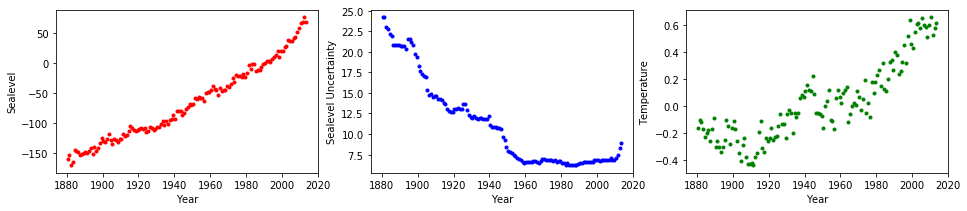

In [4]:
fig,ax = plt.subplots(nrows = 1, ncols = 3,figsize=(16,3))
ax[0].plot(year,sealevel,'r.')
ax[1].plot(year,sealevel_sigma,'b.')
ax[2].plot(year,temperature_hist,'g.')
ax[0].set_ylabel('Sealevel')
ax[1].set_ylabel('Sealevel Uncertainty')
ax[2].set_ylabel('Temperature')
for i in range(3): ax[i].set_xlabel('Year')
plt.show()

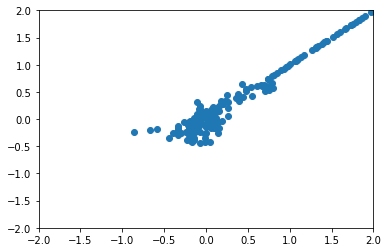

In [5]:
plt.scatter(dfTemperature["CNRM annual RCP8.5 temp. with respect to 20th century"], dfTemperature["Historical NOAA temp & CNRM RCP 8.5 with respect to 20th century"])
plt.xlim([-2,2])
plt.ylim([-2,2])
plt.show()

In [6]:
def generate_level(paramaters, temperatures, deltat):
    alpha, Teq, S0 = parameters[0], parameters[1], parameters[2]
    S = [0]*(len(temperatures)+1)
    S[0] = S0
    for i in range(1,len(temperatures)+1):
        S[i] = S[i-1] + deltat * alpha * (temperatures[i-1] - Teq)
    return S[1:]

def build_ar1(rho, sigma_ar, length):
    ar1 = []
    for i in range(length):
        temp1 = [rho**j for j in range(i,0,-1)]
        temp2 = [rho**j for j in range(length-i)]
        ar1.append(np.array(temp1+temp2))
    ar1 = np.multiply(np.array(ar1), (sigma_ar**2)/(1-rho**2))
    return ar1

def update_cov(X, s_d):
    cov = np.cov([X[:,0],X[:,1],X[:,2],X[:,3],X[:,4]])
    eps = 0.0001
    I_d = np.identity(5)
    return s_d*cov + I_d*eps*s_d

def prior(theta, sealevel_0, unc_0):
    log_prior = 0
    alpha, Teq, S0, rho, sigma_ar = (
        theta[0], theta[1], theta[2], theta[3], theta[4])
    log_prior += stats.uniform.logpdf(alpha, loc = 0, scale = 5) #lb and ub?
    log_prior += stats.uniform.logpdf(Teq, loc=-1, scale = 2)
    log_prior += stats.norm.logpdf(S0, loc = sealevel_0, scale = unc_0)
    log_prior += stats.uniform.logpdf(rho, loc = 0, scale = 1)
    log_prior += stats.uniform.logpdf(sigma_ar, loc = 0, scale = 5)
    #log_prior += np.log(stats.invgamma.pdf(sigma_ar, a = 0, scale = 5))

    return log_prior

In [57]:
temperatures = temperature_hist
def logp(theta, sealevel, deltat, temperatures, sigma=sealevel_sigma):
    N = len(sealevel)
    alpha, Teq, S0, rho, sigma_ar = (
        theta[0], theta[1], theta[2], theta[3], theta[4])
    model = generate_level(theta, temperatures, deltat)
    resid = np.array([sealevel[i] - model[i] for i in range(len(model))])
    sigma_obs = np.diag([i**2 for i in sigma])
    sigma_ar1 = build_ar1(rho, sigma_ar, N)
    log_prior = prior(theta, sealevel[0], sealevel_sigma[0])
    if np.isinf(log_prior): return -np.inf
    cov = np.add(sigma_obs,sigma_ar1)
    #print(linalg.eig(sigma_ar1))
    cov = np.multiply((np.transpose(cov) + cov), 1/2)
    log_likelihood = stats.multivariate_normal.logpdf(resid, cov=cov)
    log_posterior = log_likelihood + log_prior
    return log_posterior

In [62]:
def chain(parameters, temperatures, deltat, sealevel, sealevel_sigma, N=10000):
    alpha, Teq, S0 = parameters[0], parameters[1], parameters[2]
    theta = parameters
    print('Initial estimate for parameters -', theta)

    lp = logp(theta, sealevel, deltat, temperatures, sigma=sealevel_sigma)
    theta_best = theta
    lp_max = lp
    theta_new = [0] * 5
    accepts = 0
    mcmc_chains = np.array([[0., 0., 0., 0., 0.]] * N)    
    step = np.array([[.1,0,0,0,0], [0,.05,0,0,0], [0,0,5,0,0],
                    [0,0,0,0.001,0],[0,0,0,0,0.1]])
    sd = 2.38**2 / len(theta)

    for i in range(N):
        if not(i%500):print(i)
        if i > 500: step = update_cov(mcmc_chains[:i], sd)
        theta_new = list(np.random.multivariate_normal(theta, step))
        lp_new = logp(theta_new, sealevel, deltat, temperatures, sigma=sealevel_sigma)
        lq = lp_new - lp
        lr = np.math.log(np.random.uniform(0, 1))
        if (lr < lq):
            theta = theta_new
            lp = lp_new
            accepts += 1
            if lp > lp_max:
                theta_best = theta
                lp_max = lp
        mcmc_chains[i] = theta
    return mcmc_chains,accepts/N*100

In [63]:
parameters = [3.4, -0.5, sealevel[0], 0.5, 3]
deltat = 1
mcmc_chains,accept_rate = chain(parameters, temperatures, deltat, sealevel, sealevel_sigma)

Initial estimate for parameters - [3.4, -0.5, -158.7, 0.5, 3]
0
500
1000
1500
2000
2500
3000
3500
4000
4500
5000
5500
6000
6500
7000
7500
8000
8500
9000
9500


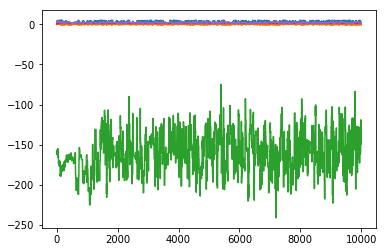

In [65]:
plt.plot(mcmc_chains)
plt.show() 

In [64]:
print(accept_rate)

16.39
